In [1]:

# Import the relevant modules
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Import CNTK
import cntk as C


import cntk.io.transforms as xforms
import cntk.tests.test_utils
#C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
    
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
import struct
import sys
    
import glob
import socket
%matplotlib inline


In [20]:
if socket.gethostname() == 'dsvm':
    root = r'/home/kumaran/Data'
else:
    root = r'E:\Temp\\'
    
data_dir = os.path.join(root, 'lfw')
#data_dir = os.path.join(root, 'MNIST')
# down data from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
# model dimensions
img_h = 36
img_w  = 36

num_channels = 3
input_dim = (num_channels, img_h, img_w)
num_classes  = 2
latent_dim = 15

e_kernel_1 = (3,3)
e_stride_1 = (2,2)
e_filter_1 = 16
e_filter_2 =  32

isFast = False
epoch_size = 30000        # 30000 samples is half the dataset size
minibatch_size = 64
num_samples_per_sweep = 60000
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) // minibatch_size
num_samples_to_test = 10000

#map_file = os.path.join(data_dir, 'cntk_image_data.tsv')

In [3]:
def create_reader_lfw(map_file, is_training):
    print("Reading map file:", map_file)    

    if not os.path.exists(map_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    # train uses data augmentation (translation only)
    if is_training and False:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8)
        ]
    transforms += [
        xforms.scale(width=img_w, height=img_w, channels=num_channels, interpolations='linear')        
    ]    
    
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        input = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [4]:
import math
import cv2
def gridPlot(images):
    n = images.shape[0]
    c = 10
    r = math.ceil(n/c)
    fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(20, 20))
         
    for i in range(n):
        if n <= c:
            axes[i].imshow(np.asarray(images[i][0].transpose(1,2,0))/255.0)
            
        else:
            ri = i//c
            ci = i%c
            axes[ri][ci].imshow(np.asarray(cv2.cvtColor(images[i][0].transpose(1,2,0)/255.0, cv2.COLOR_BGR2RGB)))
            axes[ri][ci].axis('off')
            axes[ri][ci].set_xticklabels([])
            axes[ri][ci].set_yticklabels([])

    fig.subplots_adjust(wspace=0, hspace=0)
    
def gridPlot2(images):
    n = images.shape[0]
    c = 10 if n > 10 else 1
    r = math.ceil(n/c)
    fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(20, 20))
         
    for i in range(n):
        if n <= c:
            axes[i].imshow(np.asarray(images[i].transpose(1,2,0))/255.0)
            
        else:
            ri = i//c
            ci = i%c
            axes[ri][ci].imshow(np.asarray(cv2.cvtColor(images[i].transpose(1,2,0)/255.0, cv2.COLOR_BGR2RGB)))
            axes[ri][ci].axis('off')
            axes[ri][ci].set_xticklabels([])
            axes[ri][ci].set_yticklabels([])

    fig.subplots_adjust(wspace=0, hspace=0)
            
        #axes[i].imshow(np.asarray(images[i][0].transpose(1,2,0), dtype=np.int32))

In [5]:
reader = create_reader_lfw(os.path.join(data_dir, 'lfw_map.tsv'), True)

map = {'input': reader.streams.input, 'label': reader.streams.labels}
data = reader.next_minibatch(50, input_map=map)

data['input'].shape

Reading map file: E:\Temp\\lfw\lfw_map.tsv


(50, 1, 3, 36, 36)

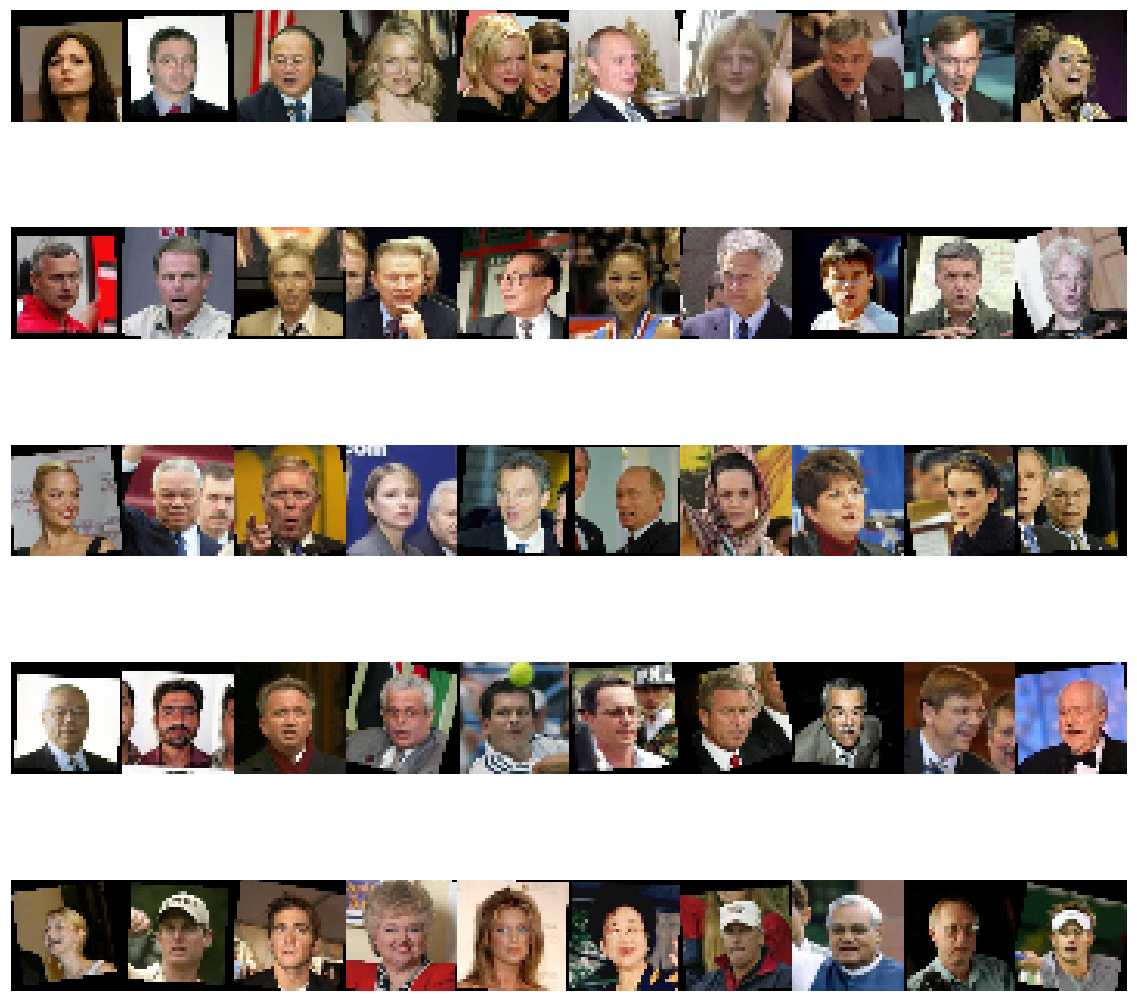

In [6]:
gridPlot(data['input'].data.asarray())

In [54]:
def discriminator(input):    
    with C.layers.default_options(init=C.normal(scale=0.02)):

        print('Discriminator convolution input shape', input.shape)
        print(e_kernel_1)
        h0 = C.layers.Convolution2D(e_kernel_1, e_filter_1, strides=e_stride_1, pad=True, activation=C.relu)(input)
        print('h0 shape :', h0.shape)
                
        h1 = C.layers.Convolution2D(e_kernel_1, e_filter_2, strides=e_stride_1, pad=True, activation=C.relu)(h0)        
        print('h1 shape :', h1.shape)
                
        p = C.layers.Dense(1, activation=C.sigmoid)(h1)        
        print('mu shape :', p.shape)
        return p
    
def generator(z):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        
        
        print('Generator input shape: ', z.shape)
        s_h2, s_w2 = img_h//2, img_w//2 #Input shape (14,14)
        s_h4, s_w4 = img_h//4, img_w//4 # Input shape (7,7)
        
        h1 = C.layers.Dense([e_filter_2, s_h4,  s_w4], activation=C.relu)(z)        
        print('h1 shape', h1.shape)

        h2 = C.layers.ConvolutionTranspose2D(e_kernel_1, num_filters=e_filter_1, strides=e_stride_1, pad=True, output_shape=(s_h2, s_w2), activation=C.relu)(h1)        
        print('h2 shape', h2.shape)

        h3 = C.layers.ConvolutionTranspose2D(e_kernel_1, num_filters=num_channels, strides=e_stride_1, pad=True, output_shape=(img_h, img_w), activation=C.tanh)(h2)
        print('h3 shape :', h3.shape)
        

        return h3

network = {}


def get_z(num_samples):
    return np.random.uniform(
        low = -1.0,
        high = 1.0,
        size = [num_samples, latent_dim]
    ).astype(np.float32)



def create_network():
    real = C.input_variable((num_channels,img_w, img_h))    
    z = C.input_variable(latent_dim)
    
    network['input'] = real
    network['z'] = z
    
    real_scaled = 2*(real / 255.0)-1

    
    network['real'] = real
    network['p_real'] = discriminator(real_scaled)
    
    #output = decoder(z)
    network['fake'] = generator(z)
    
    # replace input of discriminator with generated fake output and predict
    network['p_fake'] = network['p_real'].clone(method='share', substitutions ={real_scaled.output : network['fake'].output})
    
    # maximize log likelyhood r being face and f being not face - inputs (z, input)
    # domain [0, inf]
    d_loss = -(C.log(network['p_real']) + C.log(1.0 - network['p_fake']))
    
    # minimize log likelyhood of f being not face - inputs (z)
    # domain [-inf, 0]
    g_loss = C.log(1.0-network['p_fake'])
    
    
    network['d_loss'] = d_loss
    network['g_loss'] = g_loss
    
    network['d_error'] = d_loss
    network['g_error'] = g_loss
    
    return network



In [55]:
def train(train_file, test_file):
    create_network()    
     # Instantiate the trainer object to drive the model training
    lr_per_sample = [0.00003]
    lr_schedule = C.learning_parameter_schedule_per_sample(lr_per_sample, epoch_size)
    # Momentum which is applied on every minibatch_size = 64 samples
    momentum_schedule = C.momentum_schedule(0.5, minibatch_size)    
    # only allow discriminator parameters to be updated
    d_learner = C.fsadagrad(network['p_real'].parameters,
                         lr=lr_schedule, momentum=momentum_schedule)    
    # only allow generator parameters to be updated
    g_learner = C.fsadagrad(network['fake'].parameters,
                         lr=lr_schedule, momentum=momentum_schedule)
    # print out loss for each model for upto 50 times
    print_frequency_mbsize = 5
        
    num_minibatches_to_train_discriminator = 2
    
    pp_G = C.logging.ProgressPrinter(print_frequency_mbsize)
    pp_D = C.logging.ProgressPrinter(print_frequency_mbsize * num_minibatches_to_train_discriminator)

    
    d_trainer = C.Trainer(network['p_real'], (network['d_loss'], network['d_error']), d_learner, pp_D)
    g_trainer = C.Trainer(network['fake'], (network['g_loss'], network['g_error']), g_learner, pp_G)

    # Map the data streams to the input and labels.
    # Note: for autoencoders input == label
    input_map = {
        'input'  : train_file.streams.input,
        'label'  : train_file.streams.labels
    }

    
    for i in range(50):
        # train discriminator
        for j in range(num_minibatches_to_train_discriminator):
            real_data = train_file.next_minibatch(minibatch_size, input_map)
            z = get_z(minibatch_size)
            batch_input = { network['input'] : real_data['input'].data, network['z']: z}
            d_trainer.train_minibatch(batch_input)
            
        
        # train one step of generator
        z = get_z(minibatch_size)
        batch_input = {network['z'] : z}
        g_trainer.train_minibatch(batch_input)
        
        
            
            
            
    

train_file = create_reader_lfw(os.path.join(data_dir, 'lfw_map.tsv'), True)

train(train_file, train_file)

Reading map file: E:\Temp\\lfw\lfw_map.tsv
Discriminator convolution input shape (3, 36, 36)
(3, 3)
h0 shape : (16, 18, 18)
h1 shape : (32, 9, 9)
mu shape : (1,)
Generator input shape:  (15,)
h1 shape (32, 9, 9)
h2 shape (16, 18, 18)
h3 shape : (3, 36, 36)


C:\Users\serajago.FAREAST\AppData\Local\Continuum\anaconda3\lib\site-packages\cntk\learners\__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


Learning rate per 1 samples: 3e-05
Learning rate per 1 samples: 3e-05
 Minibatch[   1-  10]: loss = 1.379398 * 640, metric = 137.94% * 640;
 Minibatch[   1-   5]: loss = -0.692515 * 320, metric = -69.25% * 320;
 Minibatch[  11-  20]: loss = 1.363550 * 640, metric = 136.35% * 640;
 Minibatch[   6-  10]: loss = -0.691120 * 320, metric = -69.11% * 320;
 Minibatch[  21-  30]: loss = 1.325827 * 640, metric = 132.58% * 640;
 Minibatch[  11-  15]: loss = -0.688396 * 320, metric = -68.84% * 320;
 Minibatch[  31-  40]: loss = 1.233046 * 640, metric = 123.30% * 640;
 Minibatch[  16-  20]: loss = -0.683776 * 320, metric = -68.38% * 320;
 Minibatch[  41-  50]: loss = 1.063713 * 640, metric = 106.37% * 640;
 Minibatch[  21-  25]: loss = -0.676543 * 320, metric = -67.65% * 320;
 Minibatch[  51-  60]: loss = 0.876085 * 640, metric = 87.61% * 640;
 Minibatch[  26-  30]: loss = -0.664829 * 320, metric = -66.48% * 320;
 Minibatch[  61-  70]: loss = 0.761324 * 640, metric = 76.13% * 640;
 Minibatch[  31-

In [ ]:
z